# California housing

This is taken from chapter 2 ("End-to-end machine learning project") of [*Hands-On Machine Learning with Scikit-Learn & Tensorflow*](http://shop.oreilly.com/product/0636920052289.do).

## Project overview

The book gives a checklist for ML projects; like any other engineering project, we should figure out what we're building before we begin building it.

### Business objective

The business objective is given as building a subsystem to integrate into a larger system that "will determine whether or not it is worth investing in a given area or not."

### System design

What type of system should be built? Given that we have labeled training data, it's a supervised learning problem. Given that the goal is to predict a value, it's a regression problem (in particular, a univariate regression problem). Finally, given the small size of the data set and that the data set is mostly static, we can use plain batch learning.

### Performance measure

There are a lot of choices, but the standard root mean square error (RMSE) works well here.

### Verify assumptions

We're assuming we want to predict prices; it's useful to know if the bigger system expects a classified output (like "cheap", "expensive", etc); the book says that predicting the price is actually what we want, so we'll continue with building a supervised regression system.

### The dataset

The dataset is in the same directory as this notebook.

In [1]:
# Get the data set.
import os
import tarfile
import requests

DOWNLOAD_ROOT = "https:/raw.githubusercontent.com/ageron/handson-ml/master"
HOUSING_PATH = "datasets/housing"
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz"
LOCAL_TGZ = "./housing.tgz"
LOCAL_CSV = "./housing.csv"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=LOCAL_TGZ):
    if os.path.exists(LOCAL_CSV):
        return True
    if not os.path.exists(LOCAL_TGZ):
        resp = requests.get(HOUSING_URL)
        if resp.status_code != 200:
            return False
        with open(LOCAL_TGZ, 'wb') as tgz:
            tgz.write(resp.content)
    with tarfile.open(LOCAL_TGZ) as tgz:
        tgz.extract_all(path='.')
    return True

In [7]:
# Load the dataset using Pandas
import pandas as pd

def load_housing_data(housing_path=LOCAL_CSV):
    if not fetch_housing_data():
        return None
    return pd.read_csv(LOCAL_CSV)

housing = load_housing_data()
data = housing.copy()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [4]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


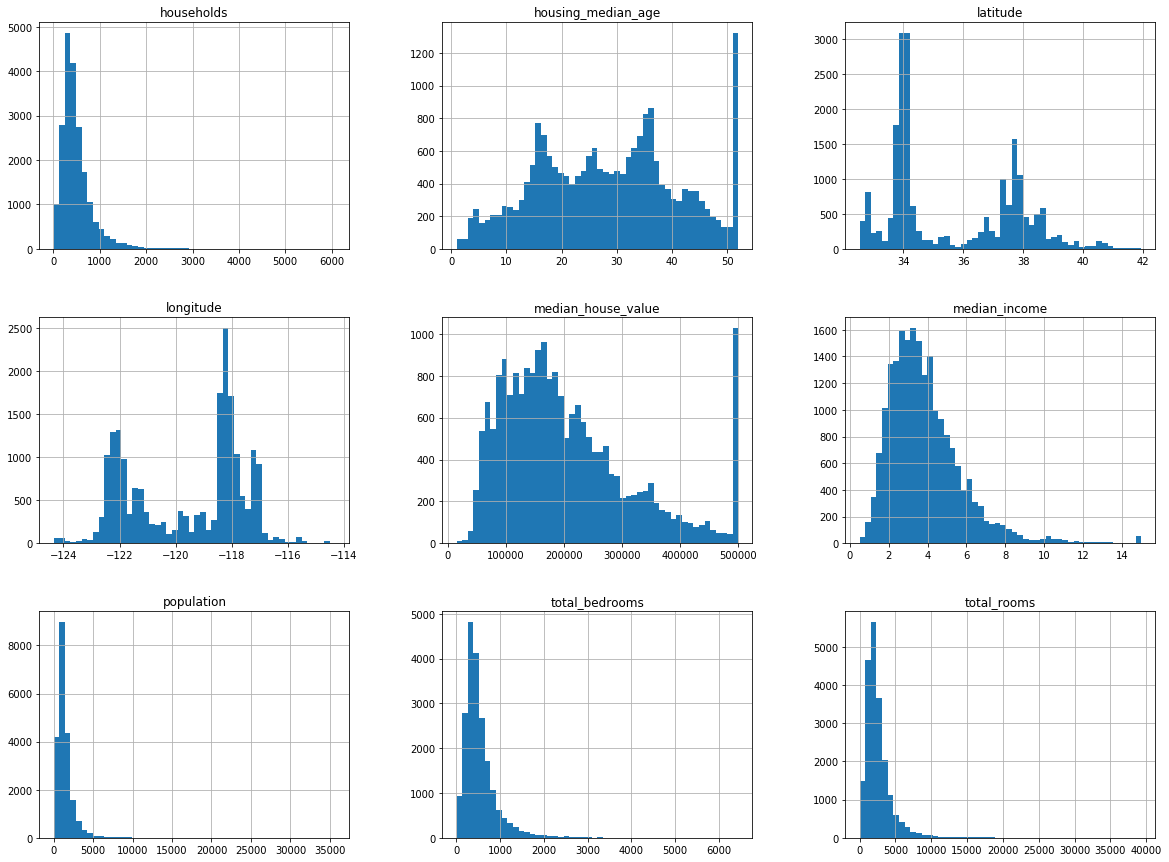

In [5]:
# Plot the data to look at it.
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

The histograms above show some interesting features:

1. The `median_income` feature doesn't appear to be in USD. It has actually been scaled and capped at 15.0001 for higher median incomes and 0.49999 for lower median incomes. We can work around this, but it's important to understand the data coming in.

2. Additionally, `housing_median_age` and `median_house_value` have also been capped. The latter is possibly a problem, because it's our target label. There are two options if the end user requires precise prices: collect proper data for these values, or remove those values from the data set.

3. The features have different scales.

4. Most of the histograms are tail heavy, extending much farther to the right of the median than to the left. We'll try to transform them into more bell-shaped distributions.

In [6]:
# Now we need to split the data into a training and test set.
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=47)

/data/data/com.termux/files/usr/lib/python3.6/site-packages/sklearn/externals/joblib/_multiprocessing_helpers.py:28: UserWarning: This platform lacks a functioning sem_open implementation, therefore, the required synchronization primitives needed will not function, see issue 3770..  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


### Building a stratified test set.

What if the data set domain experts mentioned that median income is important attribute in predicting median housing prices? It happens to be continuous, so we'll need to convert it to a category. We can build income categories by dividing the median income by 1.5, rounding up using `ceil`, and merging all categories > 5 into category 5.

In [9]:
import numpy as np
housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

In [14]:
# Do a stratified sampling based on the income category using scikit-learn's StratifiedShuffleClass.
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=47)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]
print("income category proportions")
print(housing["income_cat"].value_counts() / len(housing))

# Remove the income categories now that we're done with the category.
for set in (strat_train_set, strat_test_set):
    set.drop(["income_cat"], axis=1, inplace=True)

income category proportions
3.0    0.350581
2.0    0.318847
4.0    0.176308
5.0    0.114438
1.0    0.039826
Name: income_cat, dtype: float64


## Discover and visualise the data

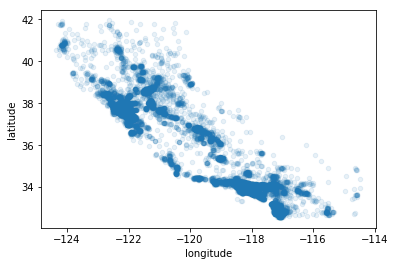

In [16]:
# Geographic plot
# The alpha parameter lets us see better those places where there is a high density of data points.

housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

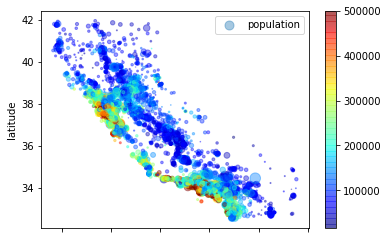

In [23]:
# Now, with colour to represent median housing cost and size to represent population.
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
             s=housing["population"]/100, label="population",
             c=housing["median_house_value"], cmap=plt.get_cmap("jet"), colorbar=True)
plt.legend()

In [25]:
# Build correlations.
correlation_matrix = housing.corr()
correlation_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.685020
total_rooms           0.134084
housing_median_age    0.098698
households            0.065762
total_bedrooms        0.049418
population           -0.025208
longitude            -0.040254
latitude             -0.150659
Name: median_house_value, dtype: float64

The correlation values range from [-1, 1]. The closer to 1 the correlation is, the stronger the *positive* correlation --- for example, a high median income tends to result in a higher median house value. The closer to -1 the correlation is, the stronger the *negative* correlation: as latitude goes up, median house value tends to go down (though not strongly), as northern California has somewhat cheaper housing. Finally, a number close to zero indicates no linear correlation.

Another way to look for correlations is with Pandas' `scatter_matrix`; this would plot each numeric attribute against each other. Instead of doing that directly (i.e. with some 100+ plots), we can focus on a few promising attributes that seem most strongly correlated.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7e3302b121d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7e32f6c5cb38>]], dtype=object)

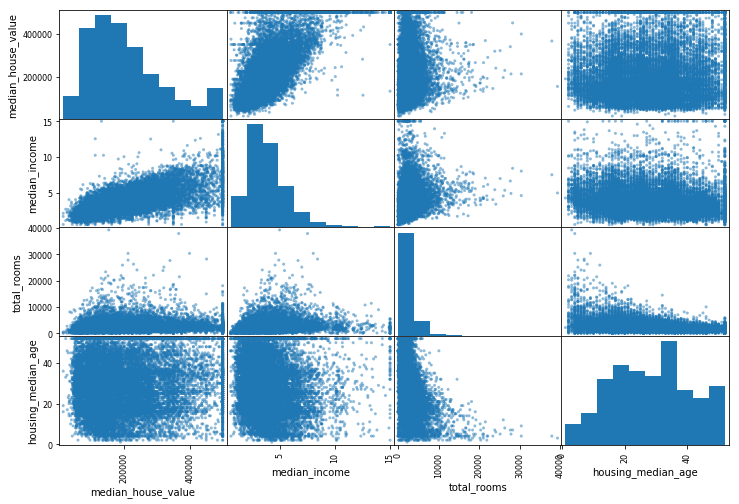

In [27]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize=(12,8))

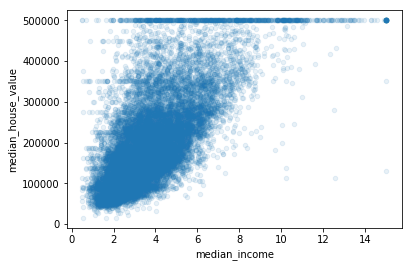

In [28]:
# Median income is the most promising, so let's focus on it.
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)

## Experimenting with attribute combinations

In looking at the data, we've already seen different ways to explore data, some potential quirks that might need to be cleaned up before building a model, interesting correlations, and candidates for data transformation. These are a few of the tools available in building a machine learning system.

Another tool is attribute combinations: for example, total number of rooms isn't terribly useful; we'd rather know the average number of rooms per household. Same for bedrooms: we'd like to know how the number of bedrooms compares to the total number of rooms. Let's create a few attribute combinations:

In [31]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

# Now look at the correlations:
correlation_matrix = housing.corr()
print(correlation_matrix["median_house_value"].sort_values(ascending=False))

median_house_value          1.000000
median_income               0.685020
rooms_per_household         0.147356
total_rooms                 0.134084
housing_median_age          0.098698
households                  0.065762
total_bedrooms              0.049418
population_per_household   -0.022267
population                 -0.025208
longitude                  -0.040254
latitude                   -0.150659
bedrooms_per_room          -0.253801
Name: median_house_value, dtype: float64


This gives us some promising new correlations:

* `bedrooms_per_room` is much more correlated to the median house value than the total number of rooms or bedrooms.
* `rooms_per_household` is more useful than either of those two as well.

The point here is to get some additional insights into the data, and it's an iterative process: build a reasonable prototype, then analyse it to build a better model.

## Prepare the data

The focus here is on building functions for data transformation rather than doing things by hand. We'll start first by reverting to a clean training set.

In [32]:
# NB: drop creates a copy of the data.
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

### Data cleaning

> Most Machine Learning algorithms cannot work with missing features

There are three options:

* Get rid of the corresponding data points
* Get rid of the whole attribute
* Set the values to some value --- zero, mean, median, some other sensible data.

The corresponding `DataFrame` methods:

* `dropna`
* `drop`
* `fillna`

In our dataset, we've got a feature with missing data: `total_bedrooms`.

```
# option 1
housing.dropna(subset=["total_bedrooms"])
# option 2
housing.drop("total_bedrooms", axis=1)
# option 3
median = housing["total_bedrooms"].median()
housing["total_bedrooms"].fillna(median)
```

If option three is chosen, make sure to save the median value for use later; you'll need this to replace missing values in future data. Scikit-learn has a class for this: `Imputer`:

In [34]:
from sklearn.preprocessing import Imputer

imputer = Imputer(strategy="median")

# Median can only be computer on numeric attributes:
housing_num = housing.drop("ocean_proximity", axis=1)

# Fit to the training data.
imputer.fit(housing_num)

print(imputer.statistics_)
print(housing_num.median().values)

[ -118.49     34.26     29.     2131.      436.     1168.      410.
     3.536]
[ -118.49     34.26     29.     2131.      436.     1168.      410.
     3.536]


In [35]:
# Use the imputer to transform the training set.
X = imputer.transform(housing_num)

# The result of this is a numpy array, which needs to be transformed back to a DataFrame.
housing_transformed = pd.DataFrame(X, columns=housing_num.columns)

### Non-numeric features

Most ML algorithms require numeric features, so let's convert the text labels to numbers.

In [38]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
print('housing_cat_encoded:', housing_cat_encoded)
print('encoder.classes:', encoder.classes_)

housing_cat_encoded: [3 1 1 ..., 1 1 3]
encoder.classes: ['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


The problem with this representation is that two nearby values will be considered more similar than distant values, which isn't good here: category 0 ('<1H OCEAN') and category 4 ('NEAR OCEAN') are more similar than category 0 and category 1 ('INLAND').

One approach to this is *one-hot encoding*, which uses one binary attribute per category; for example, `[1 0 0 0 0]` for '<1H OCEAN', `[0 1 0 0 0]` for 'INLAND', etc. Naturally, sklearn has a `OneHotEncoder`.

In [41]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

# fit_transform expects a 2D array, but housing_cat_encoded is a 1D array, so we'll need to reshape it.
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))
print(housing_cat_1hot.shape)

(16512, 5)


In [45]:
# The result is a output is a SciPy matrix, which is more memory efficient than a NumPy array of mostly zeroes.
# Note that can be converted to a NumPy array using the `toarray` method. But, uh, don't do that. It's not necessary.

# The Scikit LabelBinarizer does both of these in one shot:
from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer()

# Use the sparse_output=True to get a SciPy sparse matrix instead of a NumPy array.
housing_cat_1hot = encoder.fit_transform(housing_cat)
print(housing_cat_1hot)

[[0 0 0 1 0]
 [0 1 0 0 0]
 [0 1 0 0 0]
 ..., 
 [0 1 0 0 0]
 [0 1 0 0 0]
 [0 0 0 1 0]]


### Custom transformers

As long as a class implements the following three methods, it can be used as a custom transformer:

* `fit` (which returns `self`)
* `transform`
* `fit_transform` (which can be gotten for free by inheriting from `sklearn.base.TransformerMixin`)

For example, this will add the combined attributes added earlier:

In [47]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_household]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)